In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import re 
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from textblob import TextBlob
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
import emoji
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, Embedding, Flatten, Dropout
from tensorflow.keras.activations import softmax
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fathy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fathy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fathy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv(r"C:\Users\fathy\Downloads\sentiment_tweets3.csv\sentiment_tweets3.csv")
df.head()

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [3]:
df['label (depression result)'].value_counts().sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of label (depression result)
0    8000
1    2314
Name: count, dtype: int64>

In [4]:
df.rename(columns={'message to examine':'text', 'label (depression result)':'labels'}, inplace=True)
df.shape 

(10314, 3)

In [5]:
def remove_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

In [6]:
def rem_urls(text):
    return re.sub(r'http\S+|WWW\s+', '', text)

In [7]:
def rem_punct(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [8]:
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

def replace_chat_words(text):
    words = text.split()
    for i, word in enumerate(words):
        if word.lower() in chat_words:
            word[i] = chat_words[word.lower()]
    return ' '.join(words)


In [9]:
stop_words = set(stopwords.words('english'))

def remove_stop_words(text):
    words = text.split()
    filltered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filltered_words)

In [10]:
def rem_emoji(text):
    return emoji.demojize(text)

In [16]:
df['text'] = df['text'].apply(lambda text: text.lower())

df['text'] = df['text'].apply(remove_html)
df['text'] = df['text'].apply(rem_urls)
df['text'] = df['text'].apply(rem_punct)
df['text'] = df['text'].apply(replace_chat_words)
df['text'] = df['text'].apply(remove_stop_words)
df['text'] = df['text'].apply(rem_emoji)
df.head()

,Index,text,labels
0,106,real good moment missssssssss much,0
1,217,reading manga,0
2,220,comeagainjen,0
3,288,lapcat need send em accountant tomorrow oddly ...,0
4,540,add myspace myspacecomlookthunder,0


In [17]:
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['labels'], random_state=42, shuffle=True, test_size=0.2)

In [18]:
tokenizer = Tokenizer(oov_token= 'nothing')
tokenizer.fit_on_texts(x_train)
tokenizer.fit_on_texts(x_test)

In [19]:
tokenizer.document_count

10314

In [20]:
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

In [21]:
max_len = max(len(tokens) for tokens in x_train_seq)
max_len

75

In [22]:
x_train_pad = pad_sequences(x_train_seq, maxlen= max_len, padding='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len, padding='post')

In [23]:
input_size = np.max(x_train_pad) + 1
input_size

19016

In [24]:
model = Sequential()
model.add(LSTM(128, input_shape=(75,1), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 75, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,465 (806.50 KB)

 Trainable params: 206,465 (806.50 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = model.fit(x_train_pad, y_train, epochs=5, batch_size=32, validation_data=(x_test_pad, y_test))

Epoch 1/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 44s 169ms/step - accuracy: 0.8948 - loss: 0.2541 - val_accuracy: 0.9375 - val_loss: 0.1649
Epoch 2/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 44s 170ms/step - accuracy: 0.9515 - loss: 0.1381 - val_accuracy: 0.9598 - val_loss: 0.1181
Epoch 3/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 38s 149ms/step - accuracy: 0.9689 - loss: 0.1041 - val_accuracy: 0.9772 - val_loss: 0.0769
Epoch 4/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 40s 154ms/step - accuracy: 0.9831 - loss: 0.0682 - val_accuracy: 0.9753 - val_loss: 0.0777
Epoch 5/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 37s 142ms/step - accuracy: 0.9855 - loss: 0.0615 - val_accuracy: 0.9796 - val_loss: 0.0778


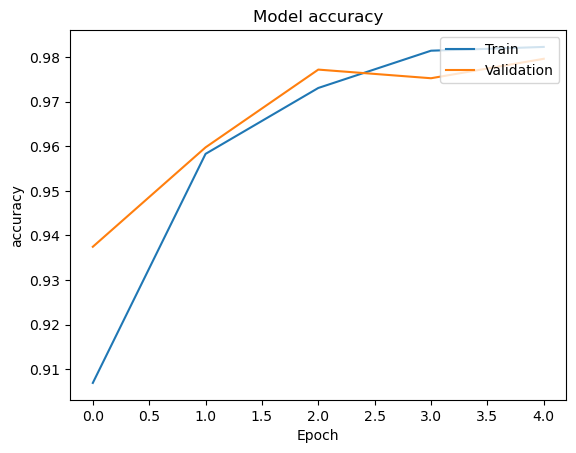

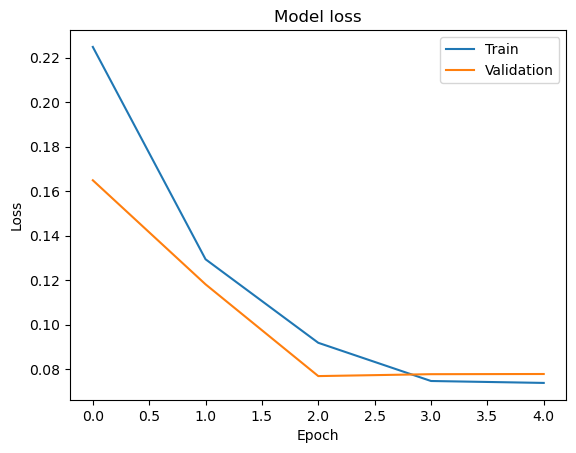

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [32]:
model.save('sentiment analysis.keras', r"Downloads")

In [43]:
text = input("inter your fedback .......\n")
text = text.lower()
text = remove_html(text)
text = rem_urls(text)
text = rem_punct(text)
text = replace_chat_words(text)
text = remove_stop_words(text)
text = rem_emoji(text)
print(text)
text_seq = tokenizer.texts_to_sequences(text)
text_pad = pad_sequences(text_seq, maxlen=max_len, padding='post')
score = model.predict(text_pad)

print(score, "1" if score.max() < 0.5 else "0")

miss sooooooooo much
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
[[0.00800536]
 [0.00800536]
 [0.00800536]
 [0.00800536]
 [0.03831307]
 [0.00800536]
 [0.0080054 ]
 [0.0080054 ]
 [0.0080054 ]
 [0.0080054 ]
 [0.0080054 ]
 [0.0080054 ]
 [0.0080054 ]
 [0.0080054 ]
 [0.0080054 ]
 [0.03831307]
 [0.00800536]
 [0.00733549]
 [0.00800479]
 [0.00800536]] 1
